## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
!pip install torchvision
!pip install matplotlib

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [3]:
model = torchvision.models.resnet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Add pruning and quantization
![Layer replacement](images/replace_layer.png)

To add pruning and quantization, we need a config file that defines how to do that. Let's load a config file from pquant/configs/configs_pdp.yaml. The training function we use later will add the pruning layers and quantized activations automatically using this config

In [4]:
from pquant import get_default_config

# pruning_methods: "autosparse, cl, cs, dst, mdmm, pdp, wanda"
pruning_method = "pdp"
config = get_default_config(pruning_method)
# Set target sparsity to 80% (20% of weights are non-zero). This parameter exists only for some pruning methods
config["pruning_parameters"]["sparsity"] = 0.8

In [5]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <PDP name=pdp, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): <QuantizedReLU name=quantized_re_lu, built=True>
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <PDP name=pdp_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): <QuantizedReLU name=quantized_re_lu_1, built=True>
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <PDP name=pdp_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <PDP name=pdp_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentu

## Pruning and quantization in the config
From the config we see that we are using the PDP pruning method, unstructured version. We aim for 80% weights pruned (sparsity 0.8), and we quantize the model to 8 bits (1 bit goes to sign). 
By default, all convolutional and linear layers, as well as activations will be quantized using the default values ```default_integer_bits``` and ```default_fractional_bits```. Similarly, by default all convolutional and linear layers will be pruned.

What is in a config? The config consists of 3 main parts: the `pruning_parameters`, the `quantization_parameters` and the `training_parameters`. The parameters outside of these at the end are values mostly related to optimizers and schedulers used in testing with a ResNet. They will be removed in the future, we don't have to worry about them. 

![Config example](images/config_example.png)

The `pruning_parameters` are different for each pruning algorithm, and they are explained in more detail [here](https://github.com/nroope/PQuant/blob/dev/docs/pruning_methods.md). 

The `quantization_parameters` are explained [here](https://github.com/nroope/PQuant/blob/dev/docs/quantization_parameters.md) 

The `training_parameters`:

Hyperparameters related to the training loop. The training loop has 3 possible stages: pretraining, training, fine-tuning. Generally speaking, during pretraining, no pruning is done, and for HGQ no loss is calculated. During training, pruning is done and HGQ loss calculated. During fine-tuning, the pruning mask is fixed and rounded to 0s and 1s. Quantization is done in all 3 stages.

![Training stages](images/training_loop.png)

If `pruning_first` is true, run pruning before quantization, else quantize first. `rewind`, `rounds` and `save_weights_epoch` are related to multi-round training (CS pruning method). `rounds` sets the number of training rounds of length `epochs`, `save_weights_epoch` sets the epoch at the first round at which to save the weights as a checkpoint. 

`rewind` defines when to reset the weights to the saved weights checkpoint, and it has 3 possible settings: 
  
   - `rounds` resets the weights back to the checkpoint after each round, 
   - `post-ticket-search` resets the weights only after all the rounds are finished
   - `never` never resets the weights


We'll show later how to create a custom quantization / pruning config file from an existing config for a given model

## About the different epochs

The config above defines 20 ```pretraining_epochs```, 100 ```epochs``` and 20 ```fine_tuning_epochs```. What stages are used and what happens during each stage is pruning algorithm specific.

![Pruning method stages](images/pruning_method_stages.png)

In PDP, the pretraining phase consists of training without pruning, followed by calculation of layerwise pruning budgets. After pretraining is finished and the layerwise pruning budgets have been calculated, the training with pruning begins. The mask during this training is a soft mask, consisting of values ranging between (and including) 0 and 1. 

The fine-tuning step in PDP is optional (not mentioned in the original paper), and during it the mask is fixed and rounded to 0s and 1s.

## Create data set
#### Let's create the data loader and the training and validation loops

In [6]:
import torchvision.transforms as transforms

def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")


def train_resnet(model, trainloader, device, loss_func, epoch, optimizer, scheduler, *args, **kwargs):
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization (1 bit for sign)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        losses = get_model_losses(model, torch.tensor(0.).to(device))
        loss += losses
        loss.backward()
        optimizer.step()
        epoch += 1
    if scheduler is not None:
        scheduler.step()


from pquant import get_layer_keep_ratio, get_model_losses

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization (1 bit for sign)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        ratio = get_layer_keep_ratio(model)
        print(f'Accuracy: {100 * correct / total:.2f}%, remaining_weights: {ratio * 100:.2f}%')

BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:02<00:00, 59.4MB/s]


## Create loss function, scheduler and optimizer

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

## Train model
Training time. We use the train_compressed_model function from pquant to train. We need to provide some parameters such as training and validation functions, their input parameters, the model and the config file. The function automatically adds pruning layers and replaces activations with a quantized variant, trains the model, and removes the pruning layers after training is done

In [8]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model = iterative_train(model = model, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )

PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp, built=True>
) target: 0.7766793966293335
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_1, built=True>
) target: 0.3998752236366272
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_2, built=True>
) target: 0.4004177451133728
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_3, built=True>
) target: 0.4018012285232544
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_4, built=True>
) target: 0.4080946147441864
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_5, built=True>
) target: 0.5405002236366272
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_6, built=True>
) target: 0.5403984785079956
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_7, built=True>
) target: 0.1947021484375
PDP Layer CompressedLayerConv2d(
  (pruning_layer): <PDP name=pdp_8, built=True>
) target: 0.5427585244178772
PDP Layer Compr

Accuracy: 84.54%, remaining_weights: 21.64%
Accuracy: 74.44%, remaining_weights: 21.64%
Accuracy: 79.93%, remaining_weights: 21.64%
Accuracy: 82.03%, remaining_weights: 21.64%
Accuracy: 77.36%, remaining_weights: 21.64%
Accuracy: 87.12%, remaining_weights: 21.64%
Accuracy: 78.65%, remaining_weights: 21.64%
Accuracy: 84.11%, remaining_weights: 21.64%
Accuracy: 86.73%, remaining_weights: 21.64%
Accuracy: 85.49%, remaining_weights: 21.64%
Accuracy: 87.27%, remaining_weights: 21.64%
Accuracy: 63.98%, remaining_weights: 21.64%
Accuracy: 81.54%, remaining_weights: 21.64%
Accuracy: 84.81%, remaining_weights: 21.64%
Accuracy: 83.44%, remaining_weights: 21.64%
Accuracy: 86.32%, remaining_weights: 21.64%
Accuracy: 84.12%, remaining_weights: 21.64%
Accuracy: 80.88%, remaining_weights: 21.64%
Accuracy: 85.86%, remaining_weights: 21.64%
Accuracy: 70.96%, remaining_weights: 21.64%
Accuracy: 86.82%, remaining_weights: 21.63%
Accuracy: 80.41%, remaining_weights: 21.63%
Accuracy: 80.67%, remaining_weig

We see from that with PDP, the number of weights goes down during training, until it reaches the target sparsity (sparsity of 80%, or ~20% remaining weights). The function that calculates the remaining weights feeds the weights through the quantizer and pruning method, and calculates the ratio between non-zero weights and all weights. However, since PDP uses a soft mask during training, the percentage of remaining weights seems to go down rather noisily (can even drop from 80% to ~20% remaining weights). The algorithm actually increases the sparsity linearly.
During fine-tuning the mask is fixed, and turned into a mask of 0s and 1s by a simple rounding operation, so the remaining weights stay the same during each epoch.

In the original paper for PDP there was no fine-tuning after the creation of the final hard mask. We have added fine-tuning here as an option that can be turned off by simply setting ```fine_tuning_epochs``` to 0 in the config file.

/tmp/ipykernel_1520326/4147432696.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


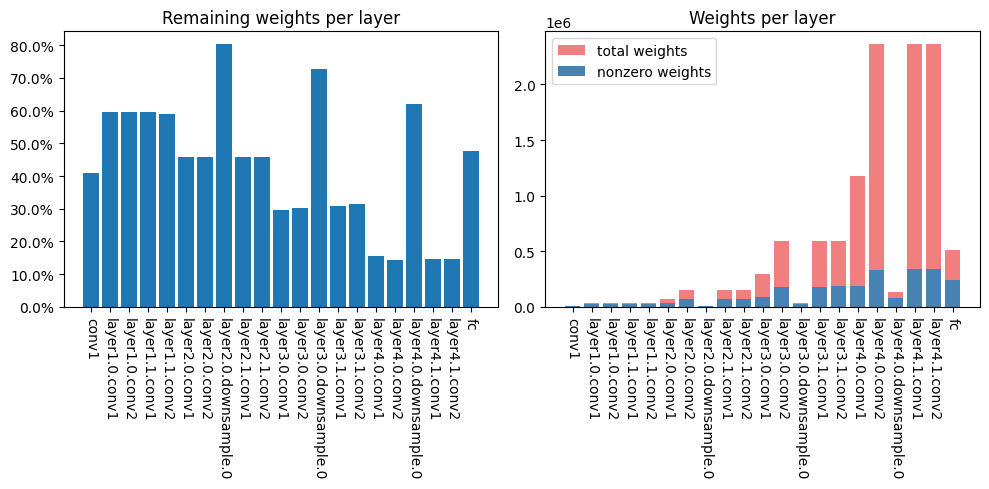

In [9]:
import numpy as np
from pquant import remove_pruning_from_model
import matplotlib.pyplot as plt
# Remove compression layers, leaves Quantized activations in place
model = remove_pruning_from_model(trained_model, config)

# Plot remaining weights
names = []
remaining = []
total_w = []
nonzeros = []
for n, m in trained_model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
plt.tight_layout()
plt.show()

## Custom config from existing config
Using the ```pquant/configs/config_pdp.yaml``` as base, let's customize the quantization and pruning scheme. 

The function we use will go through the model's layers and do the following: 

Quantization:

        1. Looks for the names of convolutional, linear and average pooling layers, as well as names of the activations (layer type activations and functional types)
        2. Adds the name of the layer to the layer_specific list, along with a default quantization scheme of 0 and 7 for weight and bias (if bias is not None)

Pruning: 

        1. Looks for convolutional and linear layers and adds their name to the disable_pruning_for_layers list.

In [10]:
# Base config
pruning_method = "pdp"
config = get_default_config(pruning_method)
model = torchvision.models.resnet18()


from pquant import add_default_layer_quantization_pruning_to_config
config = add_default_layer_quantization_pruning_to_config(model, config)
config

{'pruning_parameters': {'disable_pruning_for_layers': ['conv1',
   'layer1.0.conv1',
   'layer1.0.conv2',
   'layer1.1.conv1',
   'layer1.1.conv2',
   'layer2.0.conv1',
   'layer2.0.conv2',
   'layer2.0.downsample.0',
   'layer2.1.conv1',
   'layer2.1.conv2',
   'layer3.0.conv1',
   'layer3.0.conv2',
   'layer3.0.downsample.0',
   'layer3.1.conv1',
   'layer3.1.conv2',
   'layer4.0.conv1',
   'layer4.0.conv2',
   'layer4.0.downsample.0',
   'layer4.1.conv1',
   'layer4.1.conv2',
   'fc'],
  'enable_pruning': True,
  'epsilon': 0.015,
  'pruning_method': 'pdp',
  'sparsity': 0.8,
  'temperature': 1e-05,
  'threshold_decay': 0.0,
  'structured_pruning': False},
 'quantization_parameters': {'default_integer_bits': 0.0,
  'default_fractional_bits': 7.0,
  'enable_quantization': True,
  'hgq_gamma': 0.0003,
  'hgq_heterogeneous': True,
  'layer_specific': {'conv1': {'weight': {'integer_bits': 0,
     'fractional_bits': 7}},
   'relu': {'integer_bits': 0, 'fractional_bits': 7},
   'layer1.0.

In [11]:
# Save config
from pquant.core.utils import write_config_to_yaml
write_config_to_yaml(config, "prune_quantize_example.yaml", sort_keys=False)

Now that we have the custom config, it is up to us to modify the quantization bits for each layer that will not use the default value. If a layer uses the default value it can be removed from the ```layer_specific``` list.

For pruning, leave those layers to the ```disable_pruning_for_layers``` list that will not be pruned, others need to be removed from the list.

## About replacing layers and activations
Layers that can currently be compressed for PyTorch models: ```nn.Conv1d, nn.Conv2d, nn.Linear nn.AvgPool1d, nn.AvgPool2d, nn.AvgPool3d```.

Activations that can currently be automatically be replaced with a quantized variant: ```nn.ReLU, nn.Tanh```. The activations are replaced by a quantized variant, found in ```pquant.core.activations_quantizer.py```.


Layers that can currently be compressed for TensorFlow models: ```Conv1D, Conv2D, Dense, DepthwiseConv2D, SeparableConv2D, AveragePooling1D, AveragePooling2D, AveragePooling3D, ReLU, Activation(tanh/relu)```. In TensorFlow the activations can also be a part of the `Dense`, `Conv2D` etc. layer, in which case this activation is extracted and added as a separate quantized layer.


## More about activations
If using layer type activations, note that if you want to keep the fine-grained control over the quantization of the activation, reusing an activation layer can cause problems, as all activations will use the quantization bits set for that particular layer. To avoid this, use a separate ```nn.Tanh``` / ```nn.ReLU``` for each activation

## HGQ
To use HGQ, enable it in the config: `config["quantization_parameters"]["use_high_granularity_quantization"] = True`. Other relevant parameters to tune are `config["quantization_parameters"]["default_integer_bits"]`, `config["quantization_parameters"]["default_fractional_bits"]`, `config["quantization_parameters"]["hgq_gamma"]`. If the parameter `config["quantization_parameters"]["hgq_heterogeneous"]` is true, HGQ learns quantization bits for each weight separately, and if false, it learns one integer and one fractional bit per layer.
When using HGQ, we advice using Adam instead of SGD as an optimizer.